# Library imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import IntegratedGradients, Saliency, Occlusion

# Helper functions

In [2]:
# This function defines a system of ordinary differential equations (ODEs)
# that models microbial growth, substrate consumption, and maintenance.
# The parameters and equations are based on biological and kinetic assumptions.

def combined_ode_system(t, y, y0_g):
    # Unpacking the state variables
    Xv, Xd, Cg, Cm, Cc = y  # Xv: viable cells, Xd: dead cells, Cg: glucose concentration, Cm: metabolic byproduct, Cc: cofactor concentration

    # Defining model parameters with scientific notation conversions
    mu_g_max = (0.74) * 10**-0.75  # Maximum specific growth rate of the cells
    Kg = (0.2) * 10**2  # Half-saturation constant for glucose uptake

    mu_c_death = (0.06) * 10**0.25  # Death rate constant
    Kc = (1) * 10**1.5  # Half-saturation constant for cofactor-dependent death rate

    k_d = (0.001) * 10**1  # Baseline death rate constant

    Y_xg = (0.052) * 10**0  # Yield coefficient of biomass on glucose

    m_k = (0.06) * 10**-2  # Maintenance energy coefficient
    k_c_maint = (0.03) * 10**0  # Cofactor maintenance constant

    Y_mx = (20) * 10**-1  # Yield coefficient of metabolic byproduct formation
    beta = (5) * 10**-0.75  # Additional metabolic byproduct term

    kc = 10**1.5  # Cofactor saturation constant for metabolic byproduct formation

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Growth rate calculations

    mu_g = 2 * ((mu_g_max * Cg) / (Kg + Cg))  # Monod-type growth function

    Xm = Y_xg * y0_g  # Maximum biomass capacity based on initial glucose

    log_x = (1 - (Xv / Xm))  # Logistic growth limitation due to space/nutrient constraints

    mu_growth = mu_g * log_x  # Effective growth rate incorporating nutrient limitations

    # Death rate calculations
    mu_death = k_d + ((mu_c_death * Cc) / (Kc + Cc)) / 2  # Death rate depends on cofactor concentration

    # Maintenance energy consumption
    maint_gc = (m_k * Cc) / (k_c_maint + Cc)  # Maintenance energy requirement function

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Defining the system of differential equations

    dXvdt = (mu_growth - mu_death) * Xv  # Change in viable cell population

    dXddt = mu_death * Xv  # Accumulation of dead cells

    dCgdt = -1 * (mu_growth / Y_xg) * Xv - maint_gc * Xv  # Glucose consumption

    dCmdt = Y_mx * (mu_growth + beta) * Xv * (Cc / (Cc + kc))  # Production of metabolic byproduct

    dCcdt = -1 * dCmdt  # Cofactor consumption (assumed to be in a 1:1 ratio with metabolic byproduct)

    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]  # Returning the derivatives as a list


In [3]:
# Initial conditions for the ODE system
y0 = np.array([0.1, 0.0, 82, 0, 20])  
# y0[0] = 0.1  -> Initial viable cell concentration (Xv)
# y0[1] = 0.0  -> Initial dead cell concentration (Xd)
# y0[2] = 82   -> Initial glucose concentration (Cg)
# y0[3] = 0    -> Initial metabolic byproduct concentration (Cm)
# y0[4] = 20   -> Initial cofactor concentration (Cc)

tspan = (0, 72)  # Time span for the simulation (from 0 to 72 hours)

# Solve the system of ODEs using the Radau method (suitable for stiff problems)
sol = solve_ivp(
    combined_ode_system,  # Function defining the ODE system
    tspan,                # Time range for the integration
    y0,                   # Initial conditions
    args=tuple([y0[2]]),  # Passing the initial glucose concentration as an argument (y0_g)
    method="Radau"        # Using Radau, an implicit solver for stiff problems
)

# Copy the solution for reference
y_true = np.copy(sol.y)  # Stores the true solution before any modifications

# Modify the solution to combine viable and dead cells into a single state
y_act = sol.y
y_act[0, :] = y_act[0, :] + y_act[1, :]  # Summing viable (Xv) and dead (Xd) cell populations

# Remove the second row (Xd) after summing it into Xv
y_act1 = np.delete(y_act, 1, axis=0)  # Deleting the second row (Xd) from the array


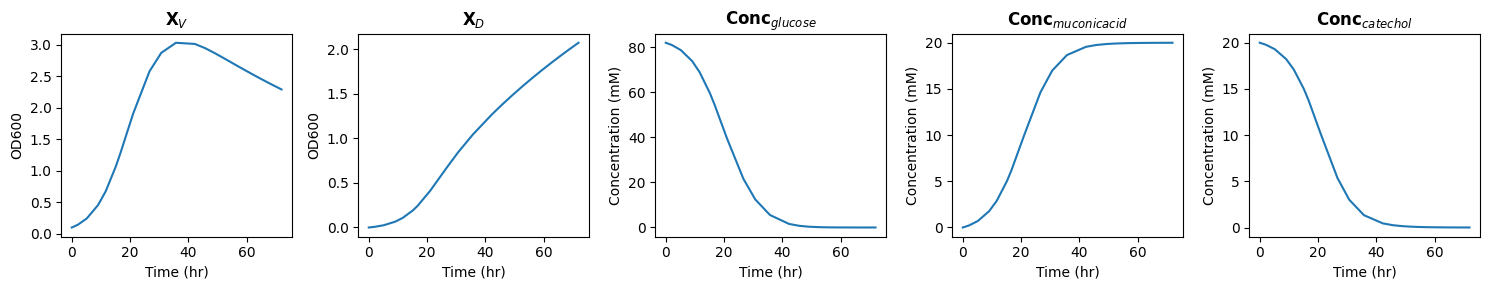

In [4]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

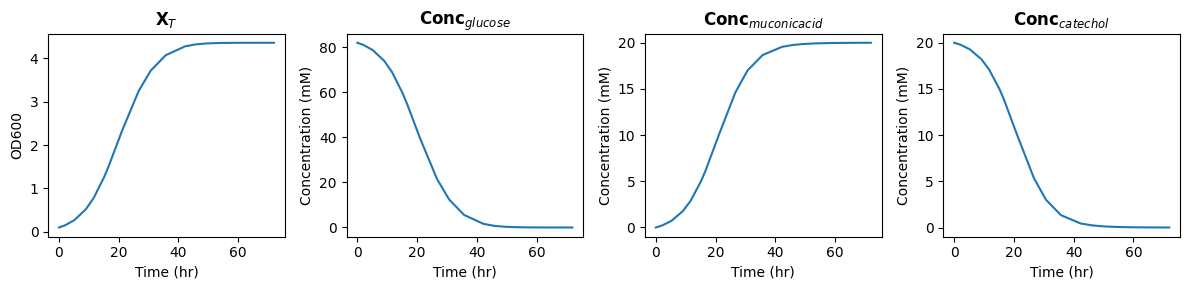

In [5]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [6]:
def syn_data_generation(num_points, file_name):
    """
    This function generates synthetic training data for a 72-hour batch bioprocess.
    It solves the ODE system for different initial conditions provided in a file.
    
    Parameters:
    - num_points (int): Number of time points for evaluation.
    - file_name (str): Name of the file containing different initial conditions.
    
    Returns:
    - time (numpy array): Time points at which the solution is evaluated.
    - sol_dict (dict): Dictionary containing simulated state trajectories for each set of initial conditions.
    """
    
    # Define the directory path to the initial conditions file
    dir_n = "Initial_conditions\\" + file_name  
    
    # Load the initial conditions from the specified file
    Init_cond = np.loadtxt(dir_n)  

    # Initialize dictionaries to store solutions and other parameters
    sol_dict = {}  # Stores simulation results for different initial conditions
    mu_dict = {}   # (Not used in this function, but could store growth rates if needed)

    # Loop through each set of initial conditions
    for i in range(len(Init_cond)):
        
        y0 = Init_cond[i, :]  # Extract initial conditions for this iteration
        tspan = (0, 72)  # Define the simulation time span (0 to 72 hours)
        teval = np.linspace(tspan[0], tspan[1], num_points)  # Generate time points for evaluation
        
        # Solve the ODE system using the Radau method (for stiff systems)
        sol = solve_ivp(
            combined_ode_system,  # ODE function
            tspan,                # Time range
            y0,                   # Initial conditions
            args=tuple([y0[2]]),  # Passing the initial glucose concentration as an argument
            method="Radau",       # Implicit solver for stiff ODEs
            t_eval=teval          # Specify time points for evaluation
        )
        
        # Process the solution data
        y_act = sol.y
        y_act[0, :] = y_act[0, :] + y_act[1, :]  # Combine viable (Xv) and dead (Xd) cell counts
        y_act = np.delete(y_act, 1, axis=0)  # Remove the dead cell row (Xd) after merging

        # Store the processed solution in the dictionary
        sol_dict[i] = y_act
        
        time = sol.t  # Store the time points for reference
    
    return [time, sol_dict]  # Return the time points and the dictionary of solutions

In [7]:
def Error_addition(num_points, file_name, per_err, rs=10):
    """
    This function generates synthetic training data using the ODE solver, then adds Gaussian noise (error) 
    to the resulting concentration profiles to simulate real-world data variation.
    
    Parameters:
    - num_points (int): Number of time points for evaluation.
    - file_name (str): Name of the file containing initial conditions.
    - per_err (float): The percentage error to be added to the data (as a proportion).
    - rs (int): Random seed for reproducibility (default is 10).
    
    Returns:
    - time (numpy array): Time points at which the solution is evaluated.
    - retreived_conc_dict (dict): Dictionary with noisy concentration profiles for each initial condition.
    """
    
    # Set the random seed for reproducibility
    random_seed = rs  
    
    # Generate the synthetic training data using the function 'syn_data_generation'
    time, s_dict = syn_data_generation(num_points, file_name)  
    
    # Extract the shape of the concentration profiles (number of species, number of time points)
    num_sp, num_t = np.shape(s_dict[0])

    # Dictionary to store the noisy concentration profiles
    retreived_conc_dict = {}

    # Iterate over each initial condition (batch run) to add error
    for i in range(len(s_dict.keys())):
        
        np.random.seed(random_seed + i)  # Ensure each batch gets a different seed for randomness
        
        # Generate Gaussian noise (random error) with mean 0 and standard deviation 'per_err'
        D_err = np.random.normal(0, per_err, size=(num_sp, num_t)) / 100
        
        # Get the concentration profiles for the current set of initial conditions
        conc_profiles = s_dict[i]
        
        # Apply the error (element-wise multiplication of concentrations and noise)
        D_final = conc_profiles + np.multiply(conc_profiles, D_err)  # Add noise to the profiles

        # Store the noisy concentration profiles in the dictionary
        retreived_conc_dict[i] = D_final

    # Return the time points and the dictionary containing the noisy concentration profiles
    return [time, retreived_conc_dict]

In [8]:
file_name = "Initial_conditions_3_1_PP.txt"
time, s = syn_data_generation(10, file_name)
t, rc = Error_addition(10,file_name, 10, rs = 5)

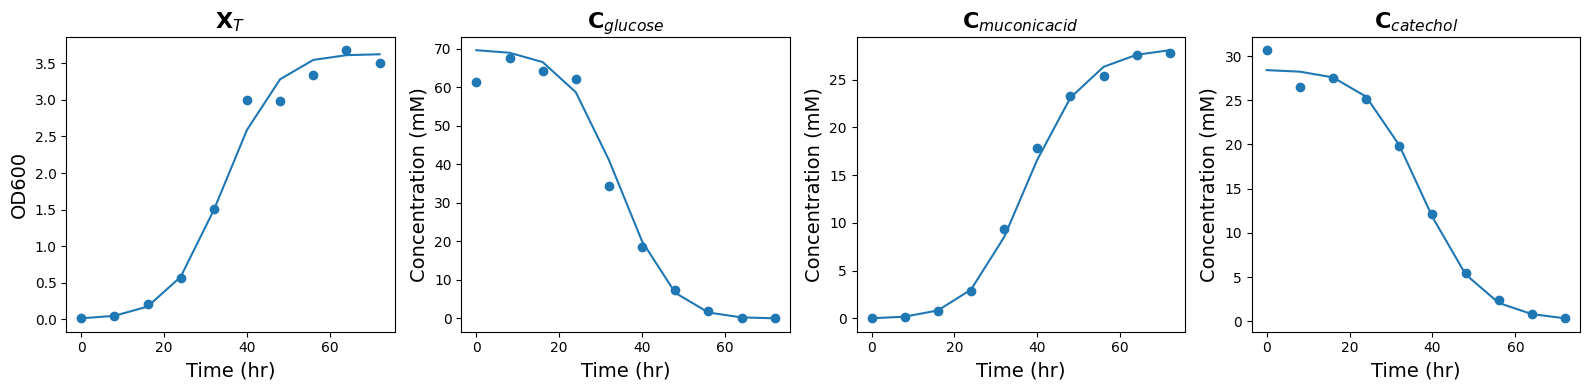

In [9]:
i = 0

fig, axs = plt.subplots(1,4,figsize = (16,4))
ax = axs.ravel()
Name = ["X$_T$", "C$_{glucose}$", "C$_{muconic acid}$", "C$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for j in range(4):
    ax[j].plot(time, s[i][j])
    ax[j].scatter(t, rc[i][j])
    ax[j].set_xlabel("Time (hr)", fontsize = 14)
    ax[j].set_ylabel(ylabels[j], fontsize = 14)
    ax[j].set_title(Name[j], fontweight = "bold", fontsize = 16)

plt.tight_layout()

# Integrated Model Construction

In [10]:
def ANN_int_mu_model(model, d, t):
    """
    This function represents an integrated Artificial Neural Network (ANN) model 
    that will be embedded within a Pyomo formulation.
    
    Parameters:
    model: Pyomo model containing ANN parameters and variables
    d: Index representing a specific data point or scenario
    t: Index representing a specific time step
    
    Returns:
    h3: Output of the ANN model at the given indices (d, t)
    """

    # Extracting input variables from the Pyomo model
    Xt = model.conc_Xt[d, t]  # Concentration of Xt
    Cg = model.conc_Cg[d, t]  # Concentration of Cg
    Cm = model.conc_Cm[d, t]  # Concentration of Cm
    Cc = model.conc_Cc[d, t]  # Concentration of Cc

    h1_list = []  # List to store activations of the first hidden layer

    # Calculating the first hidden layer activations
    for i in model.h1_num_nod:
        # Weighted sum of inputs plus bias for each node in the first hidden layer
        z1 = (
            model.W1[0, i] * Xt +
            model.W1[1, i] * Cg +
            model.W1[2, i] * Cm +
            model.W1[3, i] * Cc +
            model.b1[i]
        )
        
        # Activation function (Sigmoid function used here)
        h1 = 1 / (1 + math.e ** (-1 * z1))  
        # Alternative activation function (commented out):
        # h1 = (math.e**(2*z1) - 1) / (math.e**(2*z1) + 1)  # Tanh activation function
        
        h1_list.append(h1)  # Storing the computed activation

    # Calculating the output layer activation
    z2 = model.b2  # Initializing with bias term
    for i in model.h1_num_nod:
        z2 += model.W2[i] * h1_list[i]  # Weighted sum of hidden layer activations

    h3 = z2  # Output of the ANN model
    
    return h3  # Returning the final output

In [11]:
def dXtdt_int_con(model, d, t):
    # Defines a constraint for the total biomass dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model
    return model.dXtdt[d, t] == mu * model.conc_Xt[d, t]  # Defines the biomass growth rate equation

def dCgdt_int_con(model, d, t):
    # Defines a constraint for glucose concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model    
    # Defines the glucose consumption rate equation
    return model.dCgdt[d, t] == -1 * model.conc_Xt[d, t] * (mu * model.Ygx) * (model.max_vals[0] / model.max_vals[1])

def dCmdt_int_con(model, d, t):
    # Defines a constraint for muconic acid concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model
    # Defines the muconic acid production rate equation
    return model.dCmdt[d, t] == (model.Ymx * mu + model.beta) * model.conc_Xt[d, t] * (
        (model.conc_Cc[d, t]) / (model.conc_Cc[d, t] + (model.kc / model.max_vals[3]))
    ) * (model.max_vals[0] / model.max_vals[2])

def dCcdt_int_con(model, d, t):
    # Defines a constraint for catechol concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    # Defines the catechol consumption rate equation
    return model.dCcdt[d, t] == -1 * model.dCmdt[d, t] * (model.max_vals[2] / model.max_vals[3])

def objective_int_SSmse(model):
    # Defines a state-space objective function for the integrated hybrid model
    # This function calculates the mean squared error (MSE) between measured and simulated concentrations
    final = 0  # Initializes the cumulative error
    # Loops over all spatial indices (d_idx) and measured time points (t_meas)
    for i in model.d_idx:
        for j in model.t_meas:
            # Accumulates squared errors for each state variable: biomass (Xt), glucose (Cg),
            # muconic acid (Cm), and catechol (Cc)
            final += (model.conc_Xt_meas[i, j] - model.conc_Xt[i, j])**2
            final += (model.conc_Cg_meas[i, j] - model.conc_Cg[i, j])**2
            final += (model.conc_Cm_meas[i, j] - model.conc_Cm[i, j])**2
            final += (model.conc_Cc_meas[i, j] - model.conc_Cc[i, j])**2
    # Computes the mean squared error by normalizing the total error
    # The denominator accounts for four state variables, the number of spatial indices, and time points
    fin = final / (4 * len(model.d_idx) * len(model.t_meas))
    return fin  # Returns the computed mean squared error

In [12]:
def make_model_int_rs_fl(rs, fl):
    """
    This function generates a Pyomo model for a bioprocess using a hybrid ODE-ANN approach. 
    The function performs the following tasks:
    1. Generates training data with initial conditions and error added using predefined functions.
    2. Scales the data for model training.
    3. Defines a Pyomo model with sets, parameters, variables, and constraints based on the training data.
    4. Uses a solver to find optimal values for the model parameters.

    Parameters:
    - rs: Random seed for data generation (for reproducibility).
    - fl: Filename that contains initial conditions for the training data.

    Returns:
    - max_vals: The maximum values used for scaling the data.
    - model: The Pyomo model object representing the ODE-ANN system.
    """

    num = 10  # Number of time points per initial condition
    err = 10  # Percentage of Gaussian noise to be added
    rs = rs   # Use the random seed specified

    # Generate the synthetic training data using the functions `syn_data_generation` and `Error_addition`.
    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    # Collect data for each concentration (Xt, Cg, Cm, Cc) into a temporary list.
    y_temp = []
    for i in range(3):  # Loop for the first three species (Xt, Cg, Cm)
        y_temp.append(rc[i])

    # Convert the temporary data into numpy arrays for easier manipulation
    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    # Get the shape of the data (dimensions for species, datasets, and time points)
    n_d, n_s, n_t = np.shape(no_touch_y)

    # Extract the time and species data
    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis=0), axis=1)  # Get the maximum values for scaling

    # Scale the data for training purposes
    y_scaled = np.zeros(np.shape(y_temp))

    # Create dictionaries for each concentration to store data in a format that Pyomo can use
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    # Normalize each concentration by dividing by its max value
    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j, t[i])] = y_temp[j, 0, i] / max_vals[0]
            y_scaled[j, 0, i] = y_temp[j, 0, i] / max_vals[0]

            Cg_dict[(j, t[i])] = y_temp[j, 1, i] / max_vals[1]
            y_scaled[j, 1, i] = y_temp[j, 1, i] / max_vals[1]

            Cm_dict[(j, t[i])] = y_temp[j, 2, i] / max_vals[2]
            y_scaled[j, 2, i] = y_temp[j, 2, i] / max_vals[2]

            Cc_dict[(j, t[i])] = y_temp[j, 3, i] / max_vals[3]
            y_scaled[j, 3, i] = y_temp[j, 3, i] / max_vals[3]

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Initialize the Pyomo model
    num_nodes = 1  # Number of nodes in the hidden layer of the ANN
    model = ConcreteModel()

    # Define sets describing the dataset
    model.d_idx = Set(initialize=range(n_d))  # Batch indices
    model.t_meas = Set(initialize=no_touch_t)  # Time indices

    # Define sets for the integrated ANN structure
    model.h1_num_nod = Set(initialize=range(num_nodes))  # Hidden layer nodes
    model.num_inputs = Set(initialize=range(n_s))  # Input variables (species concentrations)

    # Parameters: Maximum values for scaling, and measured concentration data
    model.max_vals = Param(range(4), initialize=max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize=Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize=Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize=Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize=Cc_dict)

    # Variables - Time invariant parameters related to the bioprocess
    model.Ygx = Var(within=NonNegativeReals)
    model.Ymx = Var(within=NonNegativeReals)
    model.beta = Var(within=NonNegativeReals)
    model.kc = Var(within=NonNegativeReals)

    # Variables for species concentrations and their derivatives
    model.time = ContinuousSet(initialize=model.t_meas, bounds=(0, 72))  # Time range (0 to 72 hours)

    model.conc_Xt = Var(model.d_idx, model.time, within=NonNegativeReals)  # Biomass concentration
    model.conc_Cg = Var(model.d_idx, model.time, within=NonNegativeReals)  # Glucose concentration
    model.conc_Cm = Var(model.d_idx, model.time, within=NonNegativeReals)  # Muconic acid concentration
    model.conc_Cc = Var(model.d_idx, model.time, within=NonNegativeReals)  # Catechol concentration

    # Derivative variables for each concentration
    model.dXtdt = DerivativeVar(model.conc_Xt, within=Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within=Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within=Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within=Reals)

    # Variables for ANN weights and biases (used in growth rate calculations)
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds=(-1, 1))
    model.b1 = Var(model.h1_num_nod, bounds=(-1, 1))
    model.W2 = Var(model.h1_num_nod, bounds=(-1, 1))
    model.b2 = Var(bounds=(-1, 1))

    # Constraints - Hybrid ODEs for each species (biomass, glucose, muconic acid, catechol)
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule=dXtdt_int_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule=dCgdt_int_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule=dCmdt_int_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule=dCcdt_int_con)

    # Objective - State space MSE (Mean Squared Error) for model fitting
    model.obj = Objective(expr=objective_int_SSmse)

    # Discretizer for Pyomo.DAE (Differential-Algebraic Equations)
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(model, nfe=n_t, ncp=2, scheme='LAGRANGE-RADAU')  # Apply Lagrange-Radau collocation method

    # Solver setup - Multistart solver (for better convergence in nonlinear models)
    solver = SolverFactory("multistart")
    results = solver.solve(model, suppress_unbounded_warning=True, iterations=50)

    # Print solver status and results
    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))  # Print the objective function value

    # Return the model and max values for future scaling or testing
    return [max_vals, model]

In [13]:
def TIV_and_ANN_int_params(model):
    """
    Extracts the time-invariant parameters and ANN weights/biases from an integrated Pyomo model.
    
    Parameters:
    - model: The integrated Pyomo model, which includes both ODEs and the embedded ANN.
    
    Returns:
    - TIV_params: Dictionary containing time-invariant model parameters (Ygx, Ymx, beta, kc).
    - ANN_params: Dictionary containing the ANN weights and biases (W1, b1, W2, b2).
    """
    
    TIV_params = {}

    # Extract time-invariant parameters from the model and store them in a dictionary
    TIV_params["Ygx"] = value(model.Ygx)  # Yield coefficient for glucose consumption
    TIV_params["Ymx"] = value(model.Ymx)  # Yield coefficient for muconic acid production
    TIV_params["beta"] = value(model.beta)  # Growth-associated production rate for muconic acid
    TIV_params["kc"] = value(model.kc)  # Constant associated with catechol consumption

    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Initialize arrays for the ANN weights and biases
    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))  # Input-to-hidden layer weights
    b1 = np.zeros((len(model.h1_num_nod), 1))  # Hidden layer biases
    W2 = np.zeros((len(model.h1_num_nod), 1))  # Hidden-to-output layer weights

    # Extract the values for weights and biases from the model
    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i, j] = value(model.W1[i, j])  # Weight for input-to-hidden layer connection

    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])  # Bias for the hidden layer
        W2[i] = value(model.W2[i])  # Weight for hidden-to-output layer connection

    # Store the extracted weights and biases in the ANN_params dictionary
    ANN_params["W1"] = W1
    ANN_params["b1"] = b1
    ANN_params["W2"] = W2
    ANN_params["b2"] = value(model.b2)  # Bias for the output layer

    # Return the extracted parameters
    return [TIV_params, ANN_params]

In [14]:
def Xy_dataset(model):
    # Initialize empty lists for features (X) and targets (y)
    X = []
    y = []

    # Iterate over the indices in model.d_idx (likely some kind of data index)
    for i in model.d_idx:
        # Iterate over the measurements in model.t_meas (likely time measurements or related)
        for j in model.t_meas:
            # Create a temporary array (tempX) of concentrations for the given indices (i, j)
            # 'value' function is likely fetching a numerical value from model attributes
            tempX = np.array([value(model.conc_Xt_meas[i,j]),  # Concentration of X at index i, j
                              value(model.conc_Cg_meas[i,j]),  # Concentration of Cg at index i, j
                              value(model.conc_Cm_meas[i,j]),  # Concentration of Cm at index i, j
                              value(model.conc_Cc_meas[i,j])   # Concentration of Cc at index i, j
                             ])
            # Append the temporary feature array (tempX) to the list X
            X.append(tempX)
            
            # Append the target value corresponding to this (i, j) pair to the list y
            # 'ANN_int_mu_model' seems to return some model's prediction value for these indices
            y.append(value(ANN_int_mu_model(model, i,j)))

    # Convert the list of features (X) and targets (y) to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Return both the features and targets as a list
    return [X, y]

## Integrated model assembly and testing

In [15]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_5_PP.txt"]

ANN_comp_dict = {}
Xy_comp_dict = {}

for fl in range(len(file_list)):
    
    print(file_list[fl])
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict, adict = TIV_and_ANN_int_params(model_rs1)
        ANN_comp_dict[file_list[fl] + str(random_seed_list[rs])] = adict
        
        X, y = Xy_dataset(model_rs1)
        Xy_comp_dict[file_list[fl] + str(random_seed_list[rs])] = [X,y]

        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_5_PP.txt
Solver status: ok
Termination Condition: optimal
0.0022929733637023714
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0018340065454438598
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0022312085308672097
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002910946343354931
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0031771005795651662
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [16]:
X_comp_dict = {}
y_comp_dict = {}

for i in list(Xy_comp_dict.keys()):
    X_comp_dict[i] = Xy_comp_dict[i][0]
    y_comp_dict[i] = Xy_comp_dict[i][1]

# ANN interpretation

In [17]:
ANN_dict = ANN_comp_dict
X_dict = X_comp_dict
y_dict = y_comp_dict

In [18]:
tempk = list(ANN_dict.keys())[0]
ANN_dict[tempk]

{'W1': array([[-0.09646217],
        [ 0.99998439],
        [ 0.08794768],
        [-0.17926966]]),
 'b1': array([[-0.10785159]]),
 'W2': array([[0.9999839]]),
 'b2': -0.4708998590934188}

In [19]:
# Initialize an empty dictionary to store the reconstructed ANN models
ANN_recon_dict = {}

# Iterate over each key in the dictionary ANN_dict (which likely contains pre-trained ANN parameters)
for i in list(ANN_dict.keys()):
    # Initialize a temporary dictionary to store the model and its associated input data for the current key
    temp_dict = {}

    # Define the neural network model architecture using PyTorch's nn.Sequential
    # The network has 4 input features, 1 hidden unit with a Tanh activation, and 1 output unit
    model = nn.Sequential(
        nn.Linear(4, 1),  # Linear layer from 4 features to 1 output
        nn.Tanh(),        # Tanh activation function
        nn.Linear(1, 1)   # Linear layer from 1 hidden unit to 1 output
    )
    
    # Retrieve the pre-trained parameters for the current model (i) from ANN_dict
    ANN_params = ANN_dict[i]
    
    # Update the model parameters using the weights and biases from ANN_dict
    # Use torch.no_grad() to ensure that the following operations don't track gradients
    with torch.no_grad():
        # Set the weight for the first linear layer using the transpose of the W1 parameter from ANN_dict
        model[0].weight.copy_(torch.from_numpy(ANN_params["W1"].T))
        # Set the bias for the first linear layer using the b1 parameter from ANN_dict
        model[0].bias.copy_(torch.from_numpy(ANN_params["b1"].reshape(1,)))
        
        # Set the weight for the second linear layer using the transpose of the W2 parameter from ANN_dict
        model[2].weight.copy_(torch.from_numpy(ANN_params["W2"].T))
        # Set the bias for the second linear layer using the b2 parameter from ANN_dict
        model[2].bias.copy_(torch.from_numpy(np.array([ANN_params["b2"]]).reshape(1,)))
    
    # Add the constructed model and its corresponding input data (X_dict[i]) to the temporary dictionary
    temp_dict["ANN"] = model
    temp_dict["X"] = torch.tensor(X_dict[i], dtype=torch.float32)  # Convert input data to PyTorch tensor
    
    # Store the temporary dictionary in the final dictionary using the current key (i)
    ANN_recon_dict[i] = temp_dict

## ANN Interpretation - Training Data

In [20]:
# Initialize an empty dictionary to store performance results for each model
performance_dict = {}

# Extract the list of keys from the reconstructed ANN models dictionary (ANN_recon_dict)
keys = list(ANN_recon_dict.keys())

# Iterate over each key (model) in the list of keys
for i in range(len(keys)):
    # Initialize a temporary dictionary to store attributes for the current model
    temp_dict = {}
    
    # Retrieve the current model and its input data (X) from the ANN_recon_dict using the key
    ANN_model = ANN_recon_dict[keys[i]]["ANN"]
    X = ANN_recon_dict[keys[i]]["X"]
    
    # Initialize the Integrated Gradients (IG) explanation method for the current model
    ig = IntegratedGradients(ANN_model)
    
    # Compute the Integrated Gradients for the model with respect to the input data X
    # 'attribute' computes the attributions (contributions) of each feature to the model's output
    # 'return_convergence_delta=True' provides the difference between successive approximations
    attr_ig, delta_ig = ig.attribute(X, return_convergence_delta=True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Convert the attributions (attr_ig) from a PyTorch tensor to a NumPy array for easier handling
    igs = attr_ig.detach().numpy()
    
    # Store the Integrated Gradients values (igs) in the temporary dictionary
    temp_dict["IGs"] = igs
    
    # Add the temporary dictionary to the performance_dict, indexed by the current key (i)
    performance_dict[keys[i]] = temp_dict

In [21]:
ig_fl = []
X_fl = []

for i in range(len(keys)):
    td = performance_dict[keys[i]]["IGs"]
    X = ANN_recon_dict[keys[i]]["X"].detach().numpy()
    
    ig_fl.append(td)
    X_fl.append(X)
    
ig_fl = np.array(ig_fl)
ig_ICs = []

i = 0
temp = np.mean(ig_fl[5*i:5*(i+1), :, :], axis = 0)
ig_ICs.append(temp)
ig_ICs = np.array(ig_ICs)

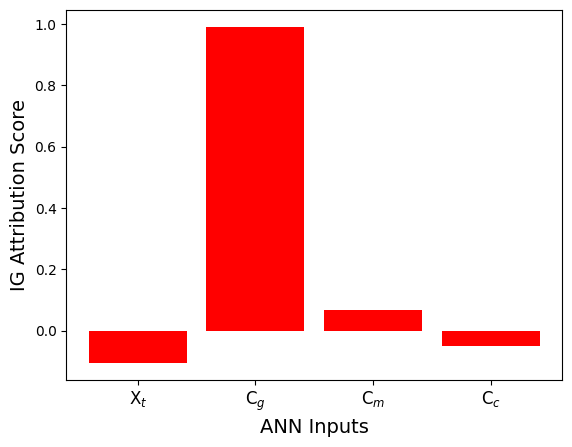

In [22]:
ig_mean = np.mean(ig_ICs[0,:,:], axis = 0)
ig_norm = ig_mean/np.linalg.norm(ig_mean)

x = 0.12*np.arange(1,5)
w = 0.1
color = ["r", "b", "y"]
plt.bar(x, ig_norm, label = "Integrated Gradeints", width = w, color = "red")
plt.ylabel("IG Attribution Score", fontsize = 14)
plt.xlabel("ANN Inputs", fontsize = 14)
plt.xticks(ticks = x, labels = ["X$_t$", "C$_g$","C$_m$","C$_c$"], fontsize = 12)
#plt.legend()
#plt.savefig("ann_att.svg")
plt.show()

In [23]:
X_fl = np.vstack(X_fl)
Ig_fl = np.vstack(ig_fl)

x_temp = X_fl
a = Ig_fl

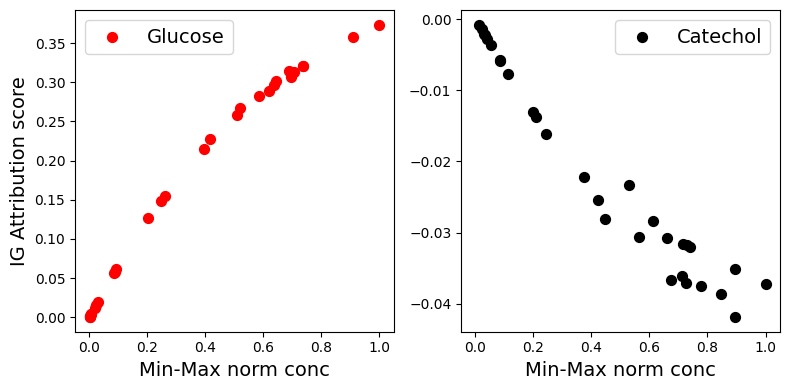

In [24]:
fig, axs = plt.subplots(1,2, figsize = (8,4), sharex = True)
ax = axs.ravel()
name = ["Glucose","Catechol"]
c = ["r", "k"]

for z in range(2):
    ax[z].scatter(x_temp[60:90,2*z+1], a[60:90,2*z+1], color = c[z], s = 50, label = name[z])
    ax[z].legend(fontsize = 14)
    ax[z].set_xlabel("Min-Max norm conc", fontsize = 14)
    if z == 0:
        ax[z].set_ylabel("IG Attribution score", fontsize = 14)
plt.tight_layout()

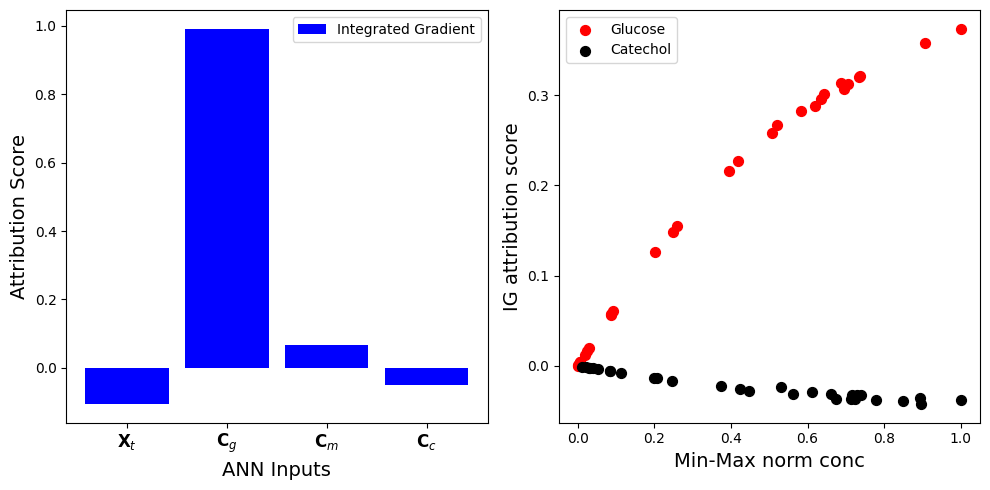

In [25]:
fig, axs = plt.subplots(1,2,figsize = (10,5))
ax = axs.ravel()

ax[0].bar(x, ig_norm, width = w, color = "b", label = "Integrated Gradient")
ax[0].set_ylabel("Attribution Score", fontsize = 14)
ax[0].set_xlabel("ANN Inputs", fontsize = 14)
ax[0].legend()
ax[0].set_xticks(ticks = x, labels = ["X$_t$", "C$_g$","C$_m$","C$_c$"], fontsize = 12, fontweight = "bold")

ax[1].scatter(x_temp[60:90,1], a[60:90,1], s = 50, c = "r", label = "Glucose")
ax[1].scatter(x_temp[60:90,3], a[60:90,3], s = 50, c = "k", label = "Catechol")
ax[1].legend()
ax[1].set_xlabel("Min-Max norm conc", fontsize = 14)
ax[1].set_ylabel("IG attribution score", fontsize = 14)

plt.tight_layout()
plt.savefig("interpretability.svg")